__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Вт 15 окт 2024 10:56:55 MSK


# загружаем данные

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_flat.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

86568

title  \
74675      2-к. квартира, 64 м², 4/8 эт.   
5146   1-комн. квартира, 30 м², 1/3 этаж   
41811    2-к. квартира, 46,6 м², 3/4 эт.   

                                                             address  \
74675                                 севастополь,улица токарева,18в   
5146   севастополь,р-н балаклавский,мкр.балаклава,улица строительная   
41811                      севастополь,улица военных строителей,12/1   

        latitude  longitude  priceM          dt  
74675  44.579641  33.504896   11.37  2024-06-07  
5146   44.512297   33.61397    4.20  2024-06-07  
41811  44.569284  33.404519    7.10  2024-09-03

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86568 entries, 0 to 86567
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   url            86568 non-null  object        
 1   place          86568 non-null  object        
 2   title          86568 non-null  object        
 3   subtitle       29366 non-null  object        
 4   price          86568 non-null  int64         
 5   address        86568 non-null  object        
 6   description    86568 non-null  object        
 7   ts             86568 non-null  datetime64[us]
 8   nrooms         86568 non-null  int64         
 9   floor          86568 non-null  int64         
 10  nfloors        86568 non-null  int64         
 11  area           86568 non-null  float64       
 12  is_studio      86568 non-null  bool          
 13  is_apartment   86568 non-null  bool          
 14  is_part        86568 non-null  bool          
 15  is_auction     8656

In [5]:
# только авито
display(len(df))
df = df[ ~df['url'].str.match(r'.*cian\.ru.*') ].reset_index(drop=True)
display(len(df)) 

86568

57202

In [6]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# df[ (df['place']=='sevastopol') & (df['address'].str.match(r'.*Судак.*')) ][cols]

---

In [7]:
# df[ df['ts'].dt.date > pd.to_datetime('2024-01-01').date() ]

In [8]:
# df_ = pd.read_pickle('data/2023/data_flat.pkl').rename(columns={'adr':'address'})
# display( len(df_) )
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page','cian_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [9]:
def address_filter(df):
    #           46.319437, 33.911048
    #
    # 45.402617, 32.455625 |  45.545301, 36.684702
    #
    #          44.320887, 33.917013

    df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
    df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

    df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 

#     df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

#     df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
#     df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

#     df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
#     df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

#     df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
#     df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

#     df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
#     df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
#     df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

#     df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
#     df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
#     df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

#     df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
#     df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

#     df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

#     df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
#     df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
#     df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
#     df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
#     df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'
#     df.loc[ df['address'].str.lower().str.match(r'.*симферопольский район.*'), 'place' ] = 'simferopol'

#    df.loc[ df['address'].str.lower().str.match(r'.*c.симферопольский район.*'), 'place' ] = 'simferopol'

    df.loc[ df['address'].str.lower().str.match(r'.*судак,село радостное.*'), 'place' ] = 'st.krym'
    df = df.dropna(subset=['latitude','longitude'])
    
    return df

In [10]:
display( len(df) )
df = address_filter(df)
# history_date = df_['dt'].max()
# df = pd.concat([df,df_])
display( len(df) )
# del df_

57202

56163

----

In [11]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

In [12]:
# display( len(df) )
# df = df.dropna(subset=['latitude','longitude'])
# display( len(df) )

----

In [13]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

56163

43103

43102

In [14]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
2437   2-к. квартира, 32,1 м², 1/2 эт.   
13881  2-к. квартира, 45,3 м², 4/5 эт.   
37016  3-к. квартира, 70,2 м², 9/9 эт.   

                                                address  latitude  longitude  \
2437                    севастополь,бакинская улица ,14     44.61      33.51   
13881                    севастополь,проспект победы,32     44.59      33.56   
37016  севастополь,проспект октябрьской революции,23 к3     44.60      33.46   

       priceM          dt  
2437     5.00  2024-08-26  
13881    6.00  2024-09-03  
37016   11.35  2024-07-30

---

In [15]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
# display( dt_min,history_date,dt_max )
print( dt_min,' : ',dt_max )

2024-06-07  :  2024-10-15


In [16]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [17]:
# display( len(gdf_history) )
display( len(gdf) )

43102

In [18]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak')")
    # .drop_duplicates(['dt','url'])
    .drop_duplicates(['url','week'])
    .reset_index(drop=True)
)
display( len(gdf) )

43102

36412

In [19]:
# # display( gdf.columns )

# display( len(gdf) )
# gdf = gdf.drop_duplicates(['url','week'])
# display( len(gdf) )

In [20]:
# gdf.columns

In [21]:
# цена за квадратный метр (тыс.руб.)
gdf['price_area_K'] = (gdf['price']/gdf['area'])/1_000

In [22]:
# gdf[ ~gdf['url'].str.match(r'.*cian\.ru.*') ] 

# общая статистика

In [23]:
# gdf[['title','address','priceM','geometry']].sample(1024).explore()

In [24]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(1024).explore()

In [25]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [26]:
# gdf_last[ gdf_last['address'].str.match(r'.*долина роз.*') ][['title','address','priceM','geometry','url']].explore()

---

In [27]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        gdf
        .groupby(['place','nrooms','week'])
#         .groupby(['place','nrooms','month'])
        ['priceM'].describe(percentiles=percentiles)
    )
    
display( stat )

count  mean  std  min   1%   5%  10%  \
place      nrooms week                                                          
sevastopol 1      2024-06-03/2024-06-09 660.00  7.01 2.01 2.70 3.66 4.50 4.80   
                  2024-06-10/2024-06-16 960.00  7.11 1.96 2.70 3.88 4.50 4.90   
                  2024-06-17/2024-06-23 846.00  7.11 1.88 2.70 3.70 4.60 4.90   
                  2024-06-24/2024-06-30 664.00  7.15 1.88 2.70 3.66 4.56 4.92   
                  2024-07-08/2024-07-14 699.00  7.34 2.36 2.80 3.55 4.50 4.85   
...                                        ...   ...  ...  ...  ...  ...  ...   
sudak      3      2024-09-16/2024-09-22  37.00  9.57 5.30 3.50 3.54 3.68 4.15   
                  2024-09-23/2024-09-29  11.00 11.11 8.13 3.70 3.73 3.85 4.00   
                  2024-09-30/2024-10-06  38.00  9.73 5.48 3.60 3.64 3.70 4.38   
                  2024-10-07/2024-10-13   7.00  5.64 1.79 3.60 3.64 3.78 3.96   
                  2024-10-14/2024-10-20  32.00  9.48 5.95 3.60 3.69 4.07 4.27   

                                         25%  50%   75%   90%   95%   max  
place      nrooms week                                                     
sevastopol 1      2024-06-03/2024-06-09 5.50 6.85  7.95  9.49 10.70 18.99  
                  2024-06-10/2024-06-16 5.70 7.09  7.90  9.30 10.20 20.00  
                  2024-06-17/2024-06-23 5.75 7.08  8.08  9.22 10.20 20.00  
                  2024-06-24/2024-06-30 5.76 7.15  8.10  9.30 10.20 16.23  
                  2024-07-08/2024-07-14 5.70 7.25  8.22  9.80 11.30 19.71  
...                                      ...  ...   ...   ...   ...   ...  
sudak      3      2024-09-16/2024-09-22 7.50 9.30  9.90 11.16 22.46 30.00  
                  2024-09-23/2024-09-29 6.10 9.90 10.59 22.73 26.36 30.00  
                  2024-09-30/2024-10-06 6.15 9.47 10.28 15.22 22.44 30.00  
                  2024-10-07/2024-10-13 4.35 5.50  6.60  7.90  8.20  8.50  
                  2024-10-14/2024-10-20 4.69 9.10 10.07 15.30 22.61 30.00  

[114 rows x 13 columns]

In [28]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
sizes = stat.reset_index()['nrooms'].unique()

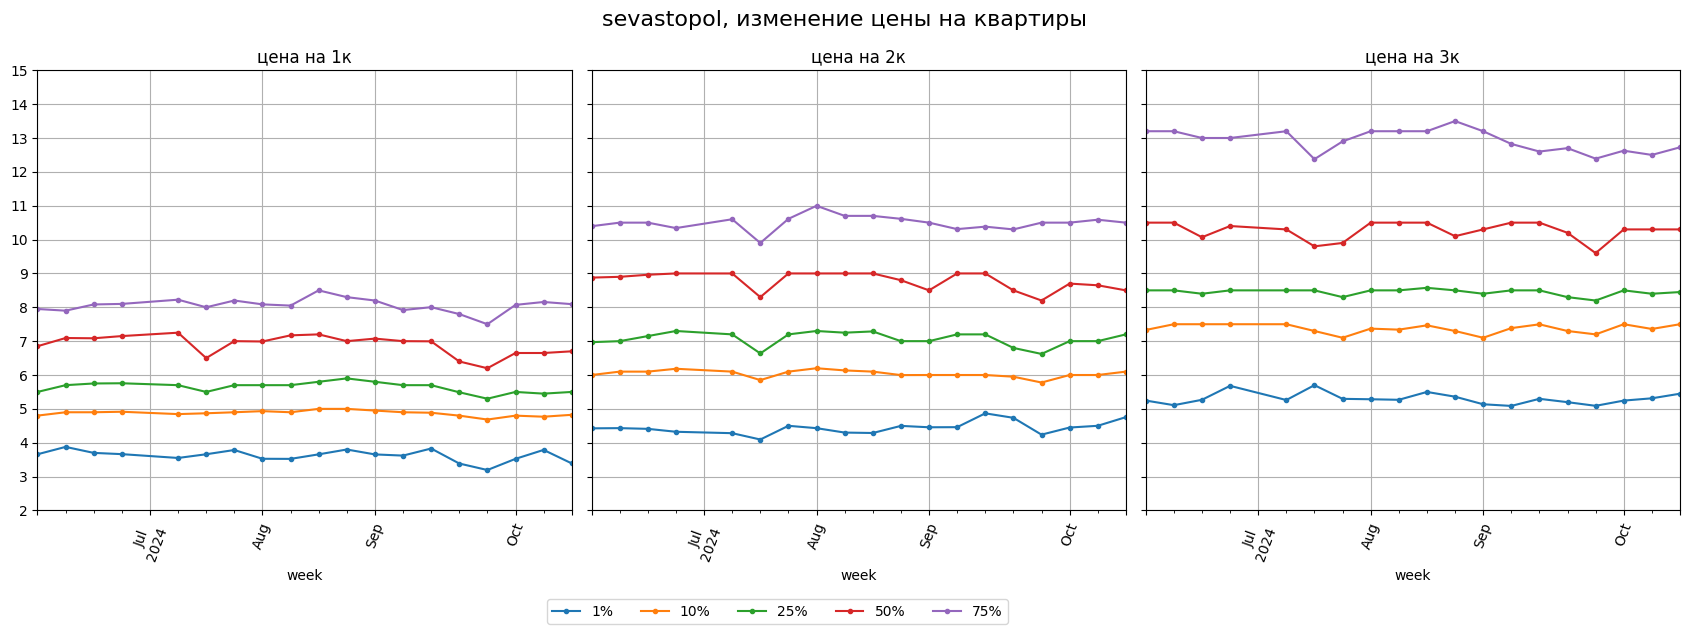

In [29]:
# history_date

place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(2, 16, step=1) )

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

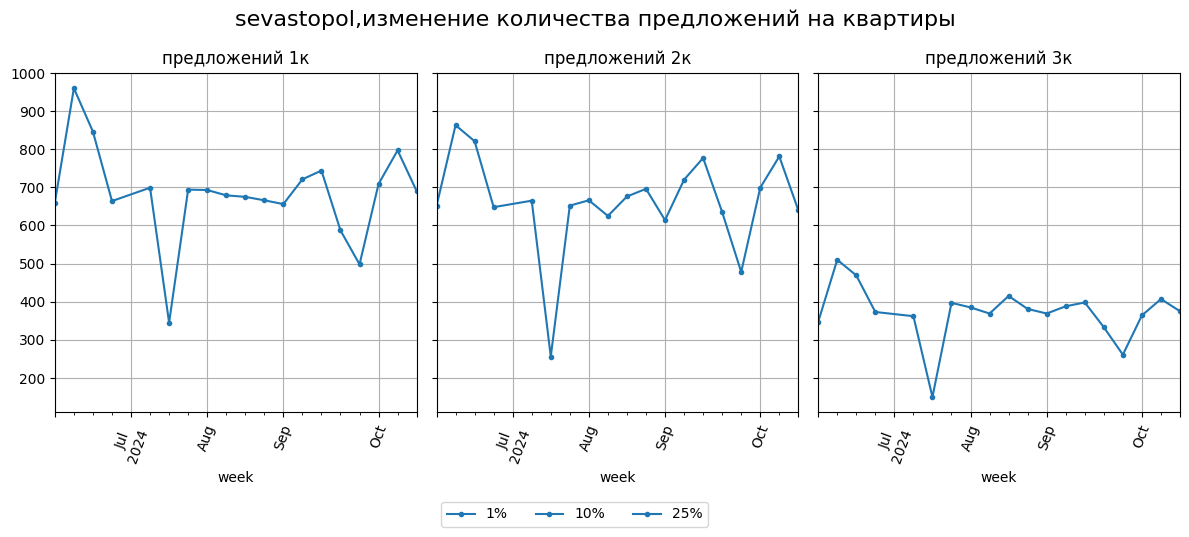

In [30]:
fig, ax = plt.subplots(1,len(sizes),figsize=(12,5), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
#     ax[i].set_yticks( np.arange(2, 16, step=1) )


fig.suptitle(f'{place},изменение количества предложений на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

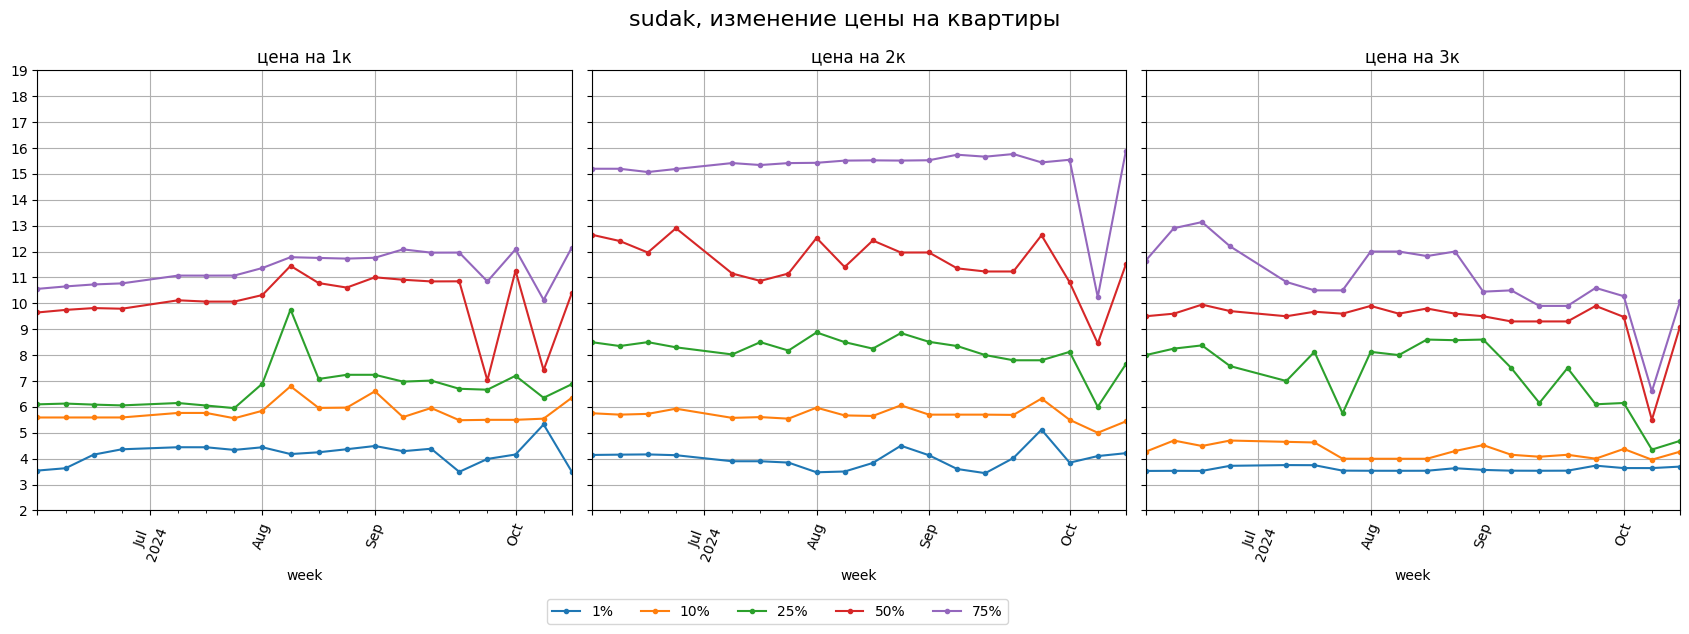

In [31]:
# history_date

place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )
for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(2, 20, step=1) )

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

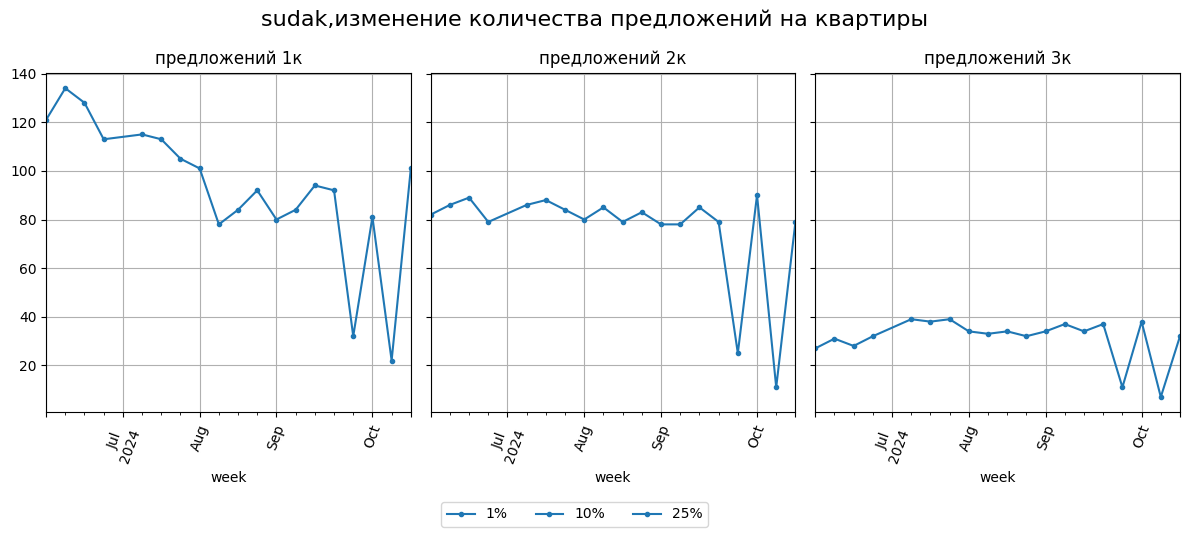

In [32]:
fig, ax = plt.subplots(1,len(sizes),figsize=(12,5), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place},изменение количества предложений на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [33]:
# sorted(gdf['dt'].unique() )

In [34]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

36412

1917

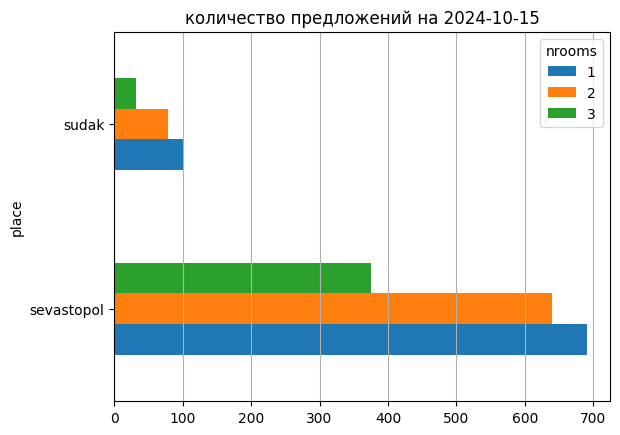

In [35]:
(
gdf_last
.drop_duplicates('url')
.groupby(['nrooms','place'])['url'].count().reset_index()
.pivot(index='place', columns='nrooms', values='url')
.plot.barh(title='количество предложений на '+ str(dt_now))
.grid(axis='x')    
)

In [36]:
(
    gdf_last
    .drop_duplicates('url')
    .groupby(['place','nrooms'])
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%   50%   75%  \
place      nrooms                                                          
sevastopol 1      690.00  7.17 2.46 2.00 3.39 4.42 4.82 5.50  6.70  8.09   
           2      640.00  9.37 3.53 3.33 4.76 5.56 6.10 7.20  8.50 10.50   
           3      375.00 11.65 5.45 3.20 5.45 6.77 7.50 8.45 10.30 12.72   
sudak      1      101.00  9.69 2.97 3.40 3.50 5.30 6.35 6.88 10.39 12.15   
           2       79.00 12.52 5.97 3.90 4.21 4.95 5.44 7.65 11.50 15.88   
           3       32.00  9.48 5.95 3.60 3.69 4.07 4.27 4.69  9.10 10.07   

                    90%   95%   max  
place      nrooms                    
sevastopol 1       9.50 13.00 19.71  
           2      13.50 15.80 31.18  
           3      17.30 22.90 49.00  
sudak      1      12.47 13.00 17.70  
           2      21.42 23.96 25.87  
           3      15.30 22.61 30.00

In [37]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

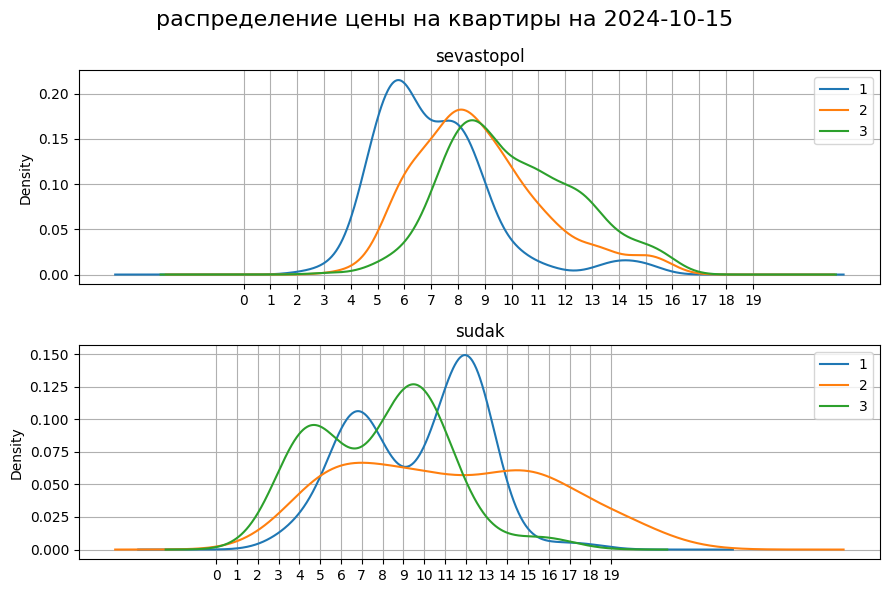

In [38]:
places = ['sevastopol','sudak',]
fig, ax = plt.subplots(len(places),1,figsize=(9,6)) #, sharex=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .drop_duplicates('url')
        .query(f'(place=="{p}")&(priceM<{q_95[p]})')
        .groupby(['nrooms'],observed=True)
        ['priceM'].plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
    ax[i].set_xticks( np.arange(0, 20, step=1) )
fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [39]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [40]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

## Севастополь

In [41]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sevastopol.explore()

In [42]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )

In [43]:
gdf_last.columns #[['']]

Index(['url', 'place', 'title', 'subtitle', 'price', 'address', 'description',
       'ts', 'nrooms', 'floor', 'nfloors', 'area', 'is_studio', 'is_apartment',
       'is_part', 'is_auction', 'is_openspace', 'is_roof', 'is_SNT', 'priceM',
       'is_last_floor', 'address_orig', 'place_', 'latitude', 'longitude',
       'dt', 'month', 'week', 'geometry', 'price_area_K'],
      dtype='object')

In [44]:
# медиана цены за квадратный метр (тыс.руб.)

grid_values = ( 
    grid
    .sjoin( gdf_last.drop_duplicates('url').query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['price_area_K']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('price_area_K',cmap='rainbow') #'area_name', legend=True)

## Судак

In [45]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [46]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=9 )

In [47]:
# медиана цены за квадратный метр (тыс.руб.)
grid_values = ( 
    grid
    .sjoin( 
        gdf_last
        .drop_duplicates('url')
        .query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['price_area_K']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('price_area_K',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [48]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

# display(frames)

In [49]:
display(frames[['area_name']])

area_name
0     Севастополь, район Острякова
1  Севастополь, парк 60-летия СССР
2  Севастополь, Хрусталёва/Хрюкина
3  Севастополь, Геловани/Коломийца
4     Севастополь, Музыки/Бирюзова
5   Севастополь, кр.горка (старый)
6    Севастополь, кр.горка (новый)
7      Севастополь, Малахов курган
8       Севастополь, Благополучный

In [50]:
frames.explore('area_name', legend=True)

In [51]:
area_name=[
# 'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
# 'Севастополь, Геловани/Коломийца',
]

In [52]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

In [53]:
# фильтруем данные по области
gdf_last_local = gdf_last.drop_duplicates('url').sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

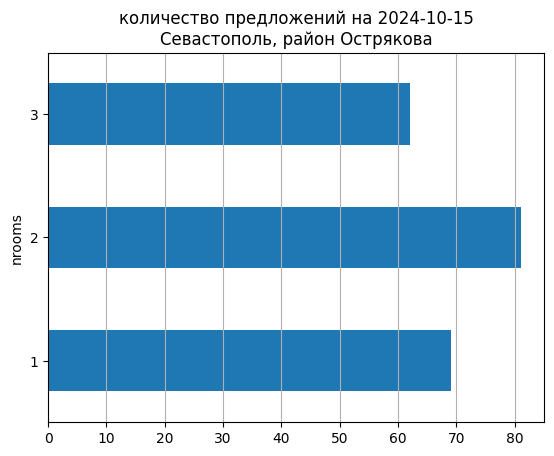

In [54]:
(
    gdf_last_local
    .drop_duplicates('url')
    .groupby(['nrooms'])['url'].count()
    .plot.barh(title='количество предложений на '+ str( dt_now ) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')   
)

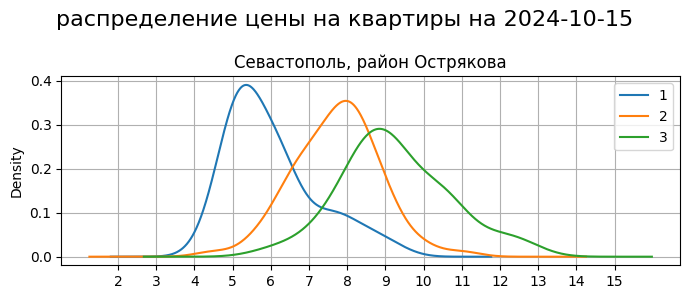

In [55]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .drop_duplicates('url')
    .groupby(['nrooms'],observed=True)
    ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)

ax.set_xticks( np.arange(2, 16, step=1) )

fig.suptitle(f'распределение цены на квартиры на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

----

In [56]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [57]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf_local.groupby(['nrooms','month'],observed=True)['priceM'].describe(percentiles=percentiles)
stat = gdf_local.groupby(['nrooms','week'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

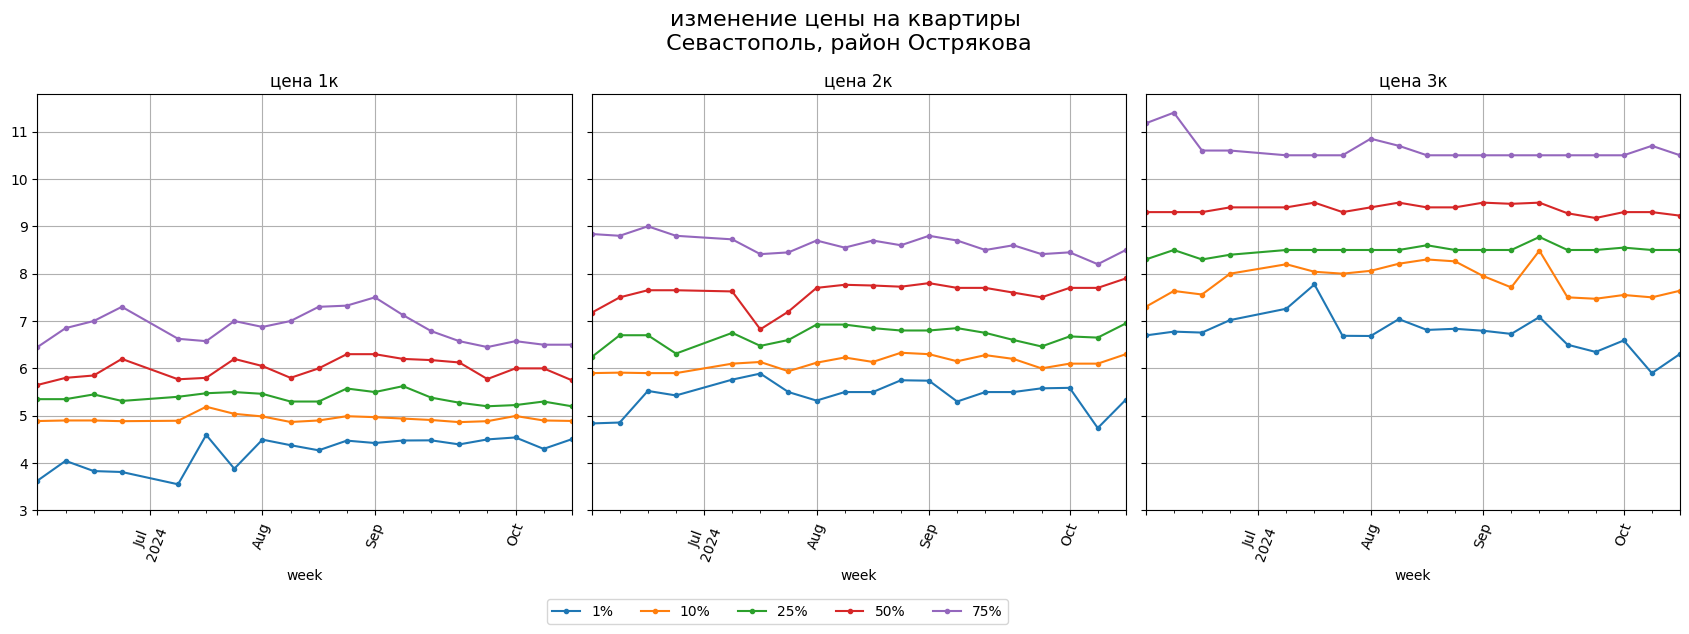

In [58]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(3, 12, step=1) )

fig.suptitle(f'изменение цены на квартиры\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

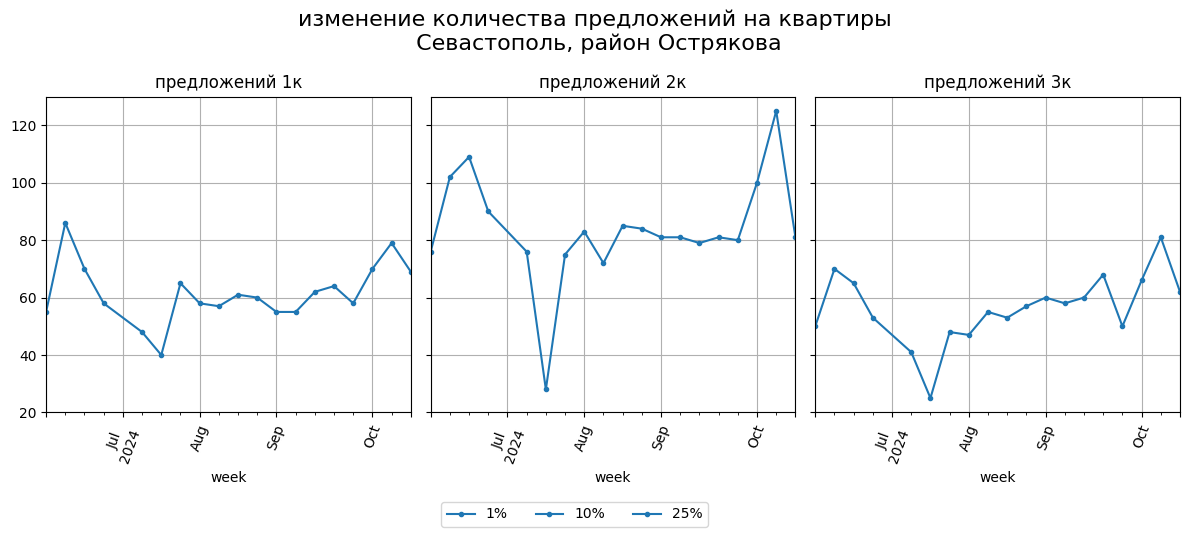

In [59]:
fig, ax = plt.subplots(1,len(sizes),figsize=(12,5), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),'count'].plot(title=f'предложений {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение количества предложений на квартиры\n {'/'.join(area_name)}', fontsize=16)

fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()